# 50-D Correlated Normal

This is a simple interactive version of the 50-D Correlated Normal demo in the documentation.

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# seed the random number generator
np.random.seed(21)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

`dynesty` supports three tiers of sampling techniques: uniform sampling for low dimensional problems, random walks for low-to-moderate dimensional problems, and slice sampling for high-dimensional problems. Here we will quickly demonstrate that slice sampling is able to cope with high-dimensional problems (efficiency "only" goes as $\propto 1/D$) using a 50-D highly correlated multivariate normal distribution.

In [4]:
ndim = 50  # number of dimensions
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms (strongly correlated)
Cinv = linalg.inv(C)  # precision matrix
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))  # ln(normalization)

# 3-D correlated multivariate normal log-likelihood
def loglikelihood(x):
    """Multivariate normal log-likelihood."""
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# prior transform
def prior_transform(u):
    """Transforms our unit cube samples `u` to a flat prior between -5. and 5. in each variable."""
    return 5. * (2. * u - 1.)

# ln(evidence)
lnz_truth = -ndim * np.log(10. * 0.999999426697)
print(lnz_truth)

-115.129225985


For slice sampling, we want to scale both the number of live points and the update interval based on the number of dimensions. Since we know this is a unimodal case, we'll initialize our sampler in the `'single'` bounding mode. 

In [5]:
# multivariate slice sampling ('slice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, update_interval=ndim*5.,
                                bound='single', sample='slice', nlive=200, slices=5)
sampler.run_nested(dlogz=0.01)
res = sampler.results

iter: 27188+200 | bound: 662 | nc: 1 | ncall: 33594655 | eff(%):  0.082 | loglstar:   -inf < 16.328 <    inf | logz: -114.671 +/-  0.759 | dlogz:  0.000 >  0.010              

In [6]:
# random slice sampling ('rslice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, update_interval=20.,
                                bound='none', sample='rslice', nlive=200, slices=15)
sampler.run_nested(dlogz=0.01)
res2 = sampler.results

iter: 26969+200 | bound: 0 | nc: 1 | ncall: 1992958 | eff(%):  1.363 | loglstar:   -inf < 14.482 <    inf | logz: -115.422 +/-  0.759 | dlogz:  0.000 >  0.010             

In [7]:
# hamiltonian slice sampling ('hslice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, update_interval=150.,
                                bound='none', sample='hslice', nlive=200, slices=10)
sampler.run_nested(dlogz=0.01)
res3 = sampler.results

iter: 27282+200 | bound: 0 | nc: 1 | ncall: 14403065 | eff(%):  0.191 | loglstar:   -inf < 15.268 <    inf | logz: -116.196 +/-  0.763 | dlogz:  0.000 >  0.010             

Now let's see how we do.

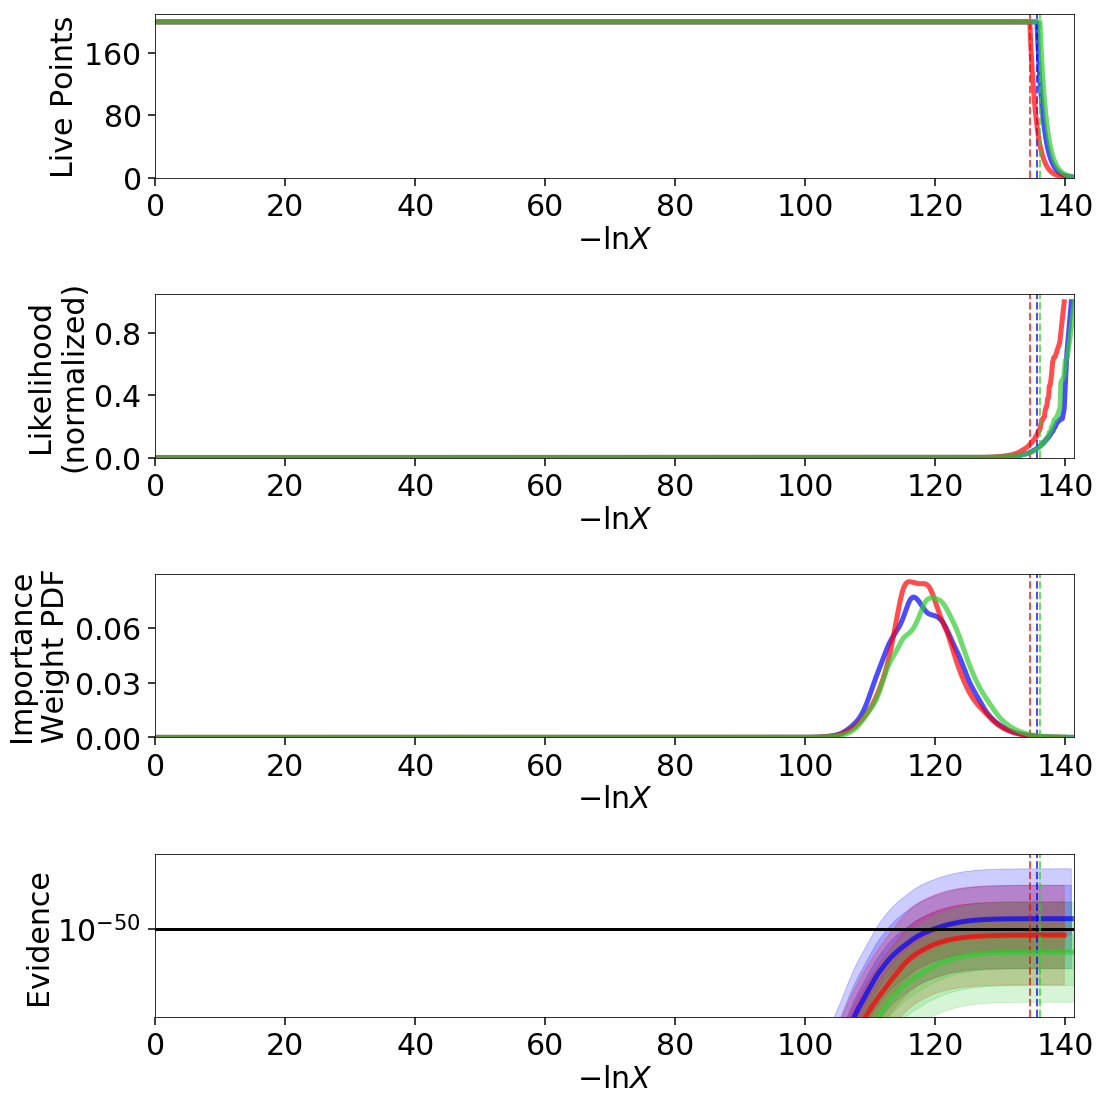

In [8]:
from dynesty import plotting as dyplot

fig, axes = dyplot.runplot(res, color='blue', logplot=True,
                           lnz_truth=lnz_truth, truth_color='black')
fig, axes = dyplot.runplot(res2, color='red', logplot=True, fig=(fig, axes))
fig, axes = dyplot.runplot(res3, color='limegreen', logplot=True, fig=(fig, axes))
fig.tight_layout()